# Introduction

PyTorch is a popular deep learning framework that was introduced around one year ago. It ha  a lower-api than Keras, but is much easier to use than TensorFlow when it comes to defining model. It is very popular among researchers and kagglers - a little less in the industry.

http://pytorch.org/

# Principles

PyTorch essentially provides the user with two main utilies:

- It allows to perform Tensor/vector computation on the GPU with an API similar (but not compatible) to Numpy.
- It records all computation to be able to backpropagate through them. That is, provided a sequence of operations that start from a tensor $\theta$ to define a scalar $g(\theta)$, it is able to compute 
$\nabla_\theta g(\theta)$ exactly, with only one function call.

    - Typically, $\theta$ will be a parameter of a neural network and
    $g$ a loss function $\ell(f_{\theta}(x), y)$, 

The essential difference with TensorFlow lies in the way $g$ is defined: in PyTorch, every computation is done dynamically, from within the Python interpreter: any Numpy code can be ported to PyTorch easily, and all flow control operation (e.g. loops, if/else, etc.) can be kept untouched. In contrast, TensorFlow requires the user to define a static graph, that it uses internally (i.e. outside the Python interpreter), to compute derivatives.

PyTorch takes care of recording everything it needs to do the backpropagation, *on the fly*.

# Installation

We will use the CPU only version for the moment. We will assume that you have a working Anaconda environment.

## On Linux:

`conda install pytorch-cpu torchvision -c pytorch`

## On OSX

`conda install pytorch torchvision -c pytorch`

## On Windows

`conda install -c peterjc123 pytorch-cpu`

Refer to https://github.com/peterjc123/pytorch-scripts for Windows installation problems.

# A first example

We will define a vector $x \in \mathbb{R}^n$ and computes its norms using PyTorch. For this, we will define our first `Tensor` -- the Tensor object is the central element of PyTorch.

Let us fill this vector with random values

In [1]:
import torch

n = 3
x = torch.FloatTensor(n).uniform_()

x is a Tensor, which can be manipulated roughly as a Numpy array

In [2]:
x


 0.9971
 0.3172
 0.2673
[torch.FloatTensor of size 3]

Let's do a small API tour

In [3]:
x.shape, x.shape[0]

(torch.Size([3]), 3)

In [4]:
x * 10


 9.9711
 3.1720
 2.6728
[torch.FloatTensor of size 3]

We can go back and forth from numpy to PyTorch tensors

In [5]:
x_np = x.numpy()

In [6]:
import numpy as np

A = torch.from_numpy(np.ones((n, n)))

A


 1  1  1
 1  1  1
 1  1  1
[torch.DoubleTensor of size 3x3]

Note that all tensors are typed and that you can only do operations with tensors of the same type

In [7]:
torch.matmul(A, x)

TypeError: torch.mv received an invalid combination of arguments - got ([32;1mtorch.DoubleTensor[0m, [31;1mtorch.FloatTensor[0m), but expected (torch.DoubleTensor source, torch.DoubleTensor vec)

In [8]:
A = A.float()

In [9]:
torch.matmul(A, x)


 1.5816
 1.5816
 1.5816
[torch.FloatTensor of size 3]

In [10]:
A @ x


 1.5816
 1.5816
 1.5816
[torch.FloatTensor of size 3]

Let us now define a norm function that returns the norm of $x$

In [11]:
def f(x: torch.FloatTensor) -> torch.FloatTensor:
    return torch.sqrt(torch.sum(x ** 2, dim=0))

In [12]:
f(x)


 1.0799
[torch.FloatTensor of size 1]

We are now interested in computing $\nabla_x f(x) = \frac{x}{|| x ||_2}$. For this, we will use the autograd facilities of PyTorch: central to it is the Variable class

In [13]:
from torch.autograd import Variable

In [14]:
x = Variable(x, requires_grad=True)

In [15]:
x

Variable containing:
 0.9971
 0.3172
 0.2673
[torch.FloatTensor of size 3]

In [16]:
x.data


 0.9971
 0.3172
 0.2673
[torch.FloatTensor of size 3]

Let us now compute the norm of f. All PyTorch functions can handle both Variables and Tensors.

In [17]:
norm = f(x)

The following `.backward()` call will assign `.grad` attributes to all Variables requires in $f$ computation for which a gradient is required.

In [18]:
norm.backward()

The gradient $\nabla_x f(x)$ can be found in `x.grad`, which is also a Variable

In [19]:
x.grad

Variable containing:
 0.9233
 0.2937
 0.2475
[torch.FloatTensor of size 3]

Let us compare it to the derivative we know:

In [20]:
y = x / f(x)

In [21]:
y

Variable containing:
 0.9233
 0.2937
 0.2475
[torch.FloatTensor of size 3]

It works ! You now know everything you need to know to use PyTorch. Note that, similar to Keras, PyTorch comes with a number of predefined functions that are useful in network definition. Check out http://pytorch.org/docs/0.3.1/ and tutorials for an overview of the tools you can use.

## Comparing gradient descent methods

In this notebook, we will use PyTorch to compare the different gradient methods and a toy 2D examples: we will try to find the minimum of the difference of two Gaussians. PyTorch provides a convenient wrapper to define parametrized functions, that we will use along this tutorial.

In [22]:
import torch.nn as nn
from torch.nn import Parameter

class Norm(nn.Module):
    def __init__(self, p: float=2.):
        super(Norm, self).__init__()
        self.p = Parameter(torch.FloatTensor([p]))
        
    def forward(self, x):
        return torch.pow(torch.sum(torch.pow(x, self.p), dim=0), 1 / self.p)

In [23]:
x = torch.FloatTensor(n).uniform_()
x = Variable(x)
norm = Norm(p=3.)
v = norm(x)
v.backward()

We can access $\nabla_p(x \to || x ||_p)$ in `norm.p.grad`

In [24]:
norm.p.grad

Variable containing:
1.00000e-02 *
 -8.3478
[torch.FloatTensor of size 1]

We now define a Gaussian operator, along with a generic Gaussian combination. We will not consider the gradient w.r.t the parameters of these modules, hence we specify `requires_grad=False`

In [25]:
from typing import List, Tuple

class Gaussian(nn.Module):
    def __init__(self, precision: torch.FloatTensor, mean: torch.FloatTensor):
        super().__init__()

        assert (precision.shape == (2, 2))
        assert (mean.shape == (2,))

        self.precision = Parameter(precision, requires_grad=False)
        self.mean = Parameter(mean, requires_grad=False)

    def forward(self, x: Variable):
        """Compute the likelihood of x given a Gaussian model.

        https://en.wikipedia.org/wiki/Multivariate_normal_distributions

        """
        # determinant = torch.potrf(self.precision).diag().prod()
        # scale = (2 * math.pi) / torch.sqrt(determinant)
        xc = x - self.mean
        value = torch.exp(- .5 * (torch.sum((xc @ self.precision)
                                            * xc, dim=1)))
        return value  # / scale


class GaussianCombination(nn.Module):
    def __init__(self, precisions: List[torch.FloatTensor],
                 means: List[torch.FloatTensor],
                 weights: List[float]) -> None:
        super().__init__()
        assert (len(precisions) == len(means) == len(weights))
        self.gaussians = nn.ModuleList()
        for precision, mean in zip(precisions, means):
            self.gaussians.append(Gaussian(precision, mean))
        self.weights = weights

    def forward(self, x: Variable) -> Variable:
        res = 0
        for gaussian, weight in zip(self.gaussians, self.weights):
            res += gaussian(x) * weight
        return res

We now define $f(x) = \exp(-(x- m_1)^T P_1 (x - m_1)) - \exp(-(x- m_2)^T P_2 (x - m_2))$

In [26]:
p1 = torch.FloatTensor([[1, 0], [0, 4]])
m1 = torch.FloatTensor([0, 1])
w1 = 1
p2 = torch.FloatTensor([[2, 0], [0, 20]])
m2 = torch.FloatTensor([0, -1])
w2 = - 1

f = GaussianCombination([p1, p2], [m1, m2], [w1, w2])

We define a plotting function to visualize $f$. Note the small boilerplate to interface PyTorch with Numpy

In [27]:
import matplotlib.pyplot as plt
def plot_function(f, ax):
    x_max, y_max, x_min, y_min = 3, 3, -3, -3
    x = np.linspace(x_min, x_max, 100, dtype=np.float32)
    y = np.linspace(y_min, y_max, 100, dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    samples = np.concatenate((X[:, :, None], Y[:, :, None]), axis=2)
    samples = samples.reshape(-1, 2)
    samples = Variable(torch.from_numpy(samples), requires_grad=False)
    Z = f(samples).data.numpy()
    Z = Z.reshape(100, 100)
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)

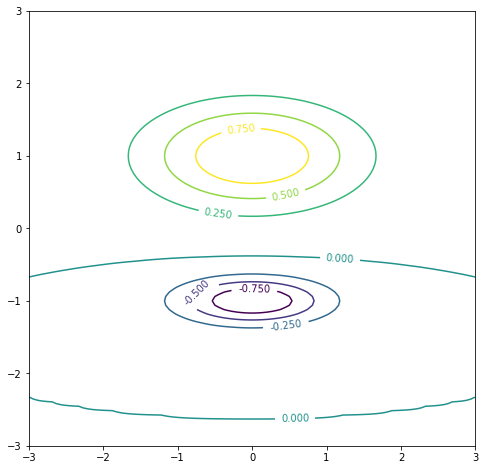

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_function(f, ax)

We will now try to minimize $f$ using gradient descent, with optional flavors. For this, we define a minimize function that performs gradient descent, along with a helper class `GradientDescent` that will perform the updates given the gradient

In [29]:
class GradientDescent:
    def __init__(self, params, lr=object(),
                 ):
        self.params = params
        self.lr = lr
        self.momentum = 0

    def step(self):
        for param in self.params:
            param.data = param.data - self.lr * param.grad.data

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()

In [33]:
def minimize(f: nn.Module, lr: float, init: torch.FloatTensor,
             optimizer: str = 'gradient_descent', max_iter: int = 100) \
        -> Tuple[torch.FloatTensor, torch.FloatTensor,]:
    # Let us now use the power of autograd to write a very
    # simple gradient descent algorithm
    # Initialization: iterate is a Tensor
    iterate = init[None, :].clone()
    # We wrap iterate in a Variable. We added an extra dimension as f handles mini-batches (Tensor of size (?, 2))
    iterate = Variable(iterate, requires_grad=True)
    if optimizer == 'gradient_descent':
        optimizer = GradientDescent([iterate], lr=lr)
    else:
        raise NotImplementedError

    value_rec = []
    iterate_rec = []

    for i in range(max_iter):
        # iterate.grad may be non zero. We free it
        optimizer.zero_grad()
        value = f(iterate)
        value.backward()
        # iterate.grad now holds $\nabla_x f(x)$
        
        # We store the trajectory of the iterates
        iterate_rec.append(iterate.data.clone())
        print('Iteration %i: f(x) = %e, x = [%e, %e]'
              % (i, value, iterate[0, 0], iterate[0, 1]))
        # Perform the gradient step
        optimizer.step()
    iterate_rec = torch.cat(iterate_rec, dim=0)
    return iterate_rec


Run the minimization algorithm and plot it

In [34]:
init = torch.FloatTensor([.8, .8])
lr = .1
iterate_rec = minimize(f, lr, init, max_iter=200)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 8.000000e-01]
Iteration 1: f(x) = 6.107973e-01, x = [8.536256e-01, 7.463744e-01]
Iteration 2: f(x) = 5.436768e-01, x = [9.057648e-01, 6.844089e-01]
Iteration 3: f(x) = 4.717643e-01, x = [9.550092e-01, 6.157771e-01]
Iteration 4: f(x) = 3.996109e-01, x = [1.000063e+00, 5.432720e-01]
Iteration 5: f(x) = 3.321852e-01, x = [1.040027e+00, 4.702666e-01]
Iteration 6: f(x) = 2.731740e-01, x = [1.074575e+00, 3.998788e-01]
Iteration 7: f(x) = 2.241067e-01, x = [1.103929e+00, 3.343038e-01]
Iteration 8: f(x) = 1.846536e-01, x = [1.128669e+00, 2.746290e-01]
Iteration 9: f(x) = 1.534765e-01, x = [1.149510e+00, 2.210520e-01]
Iteration 10: f(x) = 1.289647e-01, x = [1.167153e+00, 1.732316e-01]
Iteration 11: f(x) = 1.096362e-01, x = [1.182205e+00, 1.305813e-01]
Iteration 12: f(x) = 9.427724e-02, x = [1.195166e+00, 9.245165e-02]
Iteration 13: f(x) = 8.194828e-02, x = [1.206433e+00, 5.822318e-02]
Iteration 14: f(x) = 7.194041e-02, x = [1.216320e+00, 2.73

In [35]:
def plot_trace(iterate_rec, ax, label=None):
    iterate_rec = iterate_rec.numpy()
    line = ax.plot(iterate_rec[:, 0], iterate_rec[:, 1], linestyle=':',
            marker='o', markersize=2, label=label)
    color = plt.getp(line[0], 'color')
    bbox_props = dict(boxstyle="square,pad=0.3", ec=color, fc='white',
                      lw=1)
    for i in range(0, len(iterate_rec), len(iterate_rec) // 10):
        ax.annotate(i, xy=(iterate_rec[i, 0], iterate_rec[i, 1]),
                    xycoords='data',
                    xytext=(5 + np.random.uniform(-2, 2),
                            5 + np.random.uniform(-2, 2)),
                    textcoords='offset points',
                    bbox=bbox_props
                    )

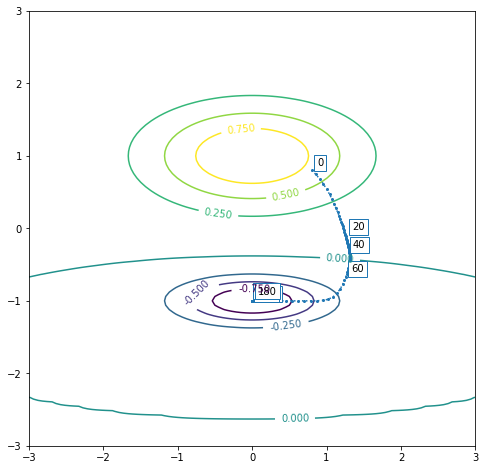

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_function(f, ax)
plot_trace(iterate_rec, ax, label='gradient_descent')

## Exercice

- Implement the MomemtumGradientDescent update
- Check that it behaves as `GradientDescent` for `momemtum = 0`
- Use `torch.optim.Adam` in the minimization loop
- Compare the three trajectories

In [39]:
from torch.optim import Adam

class MomentumGradientDescent(GradientDescent):
    def __init__(self, params, lr, momentum=.9):
        super().__init__(params, lr)
        self.momentum = momentum
        self.velocities = [param.data.new(param.shape).zero_()
                           for param in params]

    def step(self):
        # TODO
        for i, (param, velocity) in enumerate(zip(self.params,
                                                  self.velocities)):
            velocity = self.momentum * velocity + (1 - self.momentum) \
                       * param.grad.data
            param.data = param.data - self.lr * velocity
            self.velocities[i] = velocity
            
            
def minimize(f: nn.Module, lr: float, init: torch.FloatTensor,
             optimizer: str = 'gradient_descent', max_iter: int = 100, verbose=True) \
        -> Tuple[torch.FloatTensor, torch.FloatTensor,]:
    # Initialization: iterate is a Tensor
    iterate = init[None, :].clone()
    # We wrap iterate in a Variable. We added an extra dimension as f handles mini-batches (Tensor of size (?, 2))
    iterate = Variable(iterate, requires_grad=True)
    if optimizer == 'gradient_descent':
        optimizer = GradientDescent([iterate], lr=lr)
    elif optimizer == 'momentum':
        optimizer =  MomentumGradientDescent([iterate], lr=lr)
    elif optimizer == 'adam':
        optimizer = Adam([iterate], lr=lr)
    else:
        raise NotImplementedError

    value_rec = []
    iterate_rec = []

    for i in range(max_iter):
        # iterate.grad may be non zero. We free it
        optimizer.zero_grad()
        value = f(iterate)
        value.backward()
        # iterate.grad now holds $\nabla_x f(x)$
        
        # We store the trajectory of the iterates
        iterate_rec.append(iterate.data.clone())
        if verbose:
            print('Iteration %i: f(x) = %e, x = [%e, %e]'
                  % (i, value, iterate[0, 0], iterate[0, 1]))
        # Perform the gradient step
        optimizer.step()
    iterate_rec = torch.cat(iterate_rec, dim=0)
    return iterate_rec

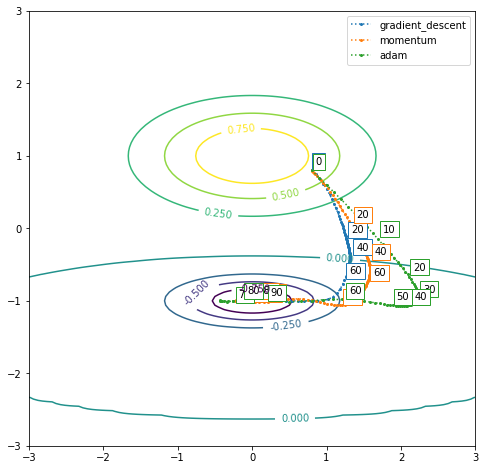

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_function(f, ax)
iterate_rec = minimize(f, lr, init=init, max_iter=200,
                                  optimizer='gradient_descent', verbose=False)
plot_trace(iterate_rec, ax, label='gradient_descent')
iterate_rec = minimize(f, lr, init=init, max_iter=200,
                                  optimizer='momentum', verbose=False)
plot_trace(iterate_rec, ax, label='momentum')
iterate_rec = minimize(f, lr, init=init, max_iter=100,
                                  optimizer='adam', verbose=False)
plot_trace(iterate_rec, ax, label='adam')
ax.legend()

What do you observe ? Try changin the momentum and the initialization to compare optimization traces